## Generate the baseline accuracy figure

In [109]:
import pandas as pd
dfs = []
for ds_name in ['PHARYNGITIS']:
    for imputation_method in ['MIWAE']:
        for s_iter in range(120):
            try:
                #df = pd.read_csv(f'./parallelized_results/baselines_2024-02_01_iter_{s_iter}_10_imp_all.csv')
                df = pd.read_csv(f'./parallelized_results/baselines_iter_{s_iter}_{ds_name}_{imputation_method}.csv')
                dfs.append(df)
            except:
                print(f"WARNING: Skipping iteration {s_iter}")
                continue
combined_acc_df = pd.concat(dfs, axis=0)

target_imp = 'MIWAE'
target_metric = 'acc'

In [110]:
mask = (combined_acc_df['num_imputations'] == 10) & \
        (combined_acc_df['missingness_handling'] == target_imp)
cur_acc_df = combined_acc_df[mask]

In [111]:
cur_acc_df['model_type'].value_counts()

GAM_no_missing            150
GAM_ind                   150
GAM_aug                   150
XGBClassifier              60
LogisticRegression         30
RandomForestClassifier     30
AdaBoostClassifier         30
DecisionTreeClassifier     30
MLPClassifier              30
Name: model_type, dtype: int64

In [112]:
def get_smim_tag(row):
    if row['use_smim']:
        return row['model_type'] + ' (SMIM)'
    else:
        return row['model_type'] + ' (No SMIM)'
cur_acc_df['model_type'] = cur_acc_df.apply(get_smim_tag, axis=1)

In [113]:
# Because we have a distinct entry for each val set for our gams,
# we need to take the average of each value along val sets
cur_acc_df = cur_acc_df.groupby(['model_type', 'dataset', 'holdout_set', 'metric', 'missingness_handling']).mean().reset_index()
cur_acc_df['model_type'].value_counts()

/tmp/ipykernel_892048/1241698487.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cur_acc_df = cur_acc_df.groupby(['model_type', 'dataset', 'holdout_set', 'metric', 'missingness_handling']).mean().reset_index()


AdaBoostClassifier (SMIM)        30
DecisionTreeClassifier (SMIM)    30
GAM_aug (SMIM)                   30
GAM_ind (SMIM)                   30
GAM_no_missing (SMIM)            30
LogisticRegression (SMIM)        30
MLPClassifier (SMIM)             30
RandomForestClassifier (SMIM)    30
XGBClassifier (No SMIM)          30
XGBClassifier (SMIM)             30
Name: model_type, dtype: int64

In [114]:
# Now lets filter down to grab just AUC for BRECA, ACC for FICO
#cur_acc_df = pd.concat([
    #cur_acc_df[(cur_acc_df['dataset'] == 'FICO') & (cur_acc_df['metric'] == 'acc')],
    #cur_acc_df[(cur_acc_df['dataset'] == 'BREAST_CANCER') & (cur_acc_df['metric'] == 'auc')]
#], axis=0)
cur_acc_df = cur_acc_df[cur_acc_df['metric'] == target_metric]


cur_acc_df = cur_acc_df[cur_acc_df['model_type'] != 'GAM_no_missing (SMIM)']

cur_acc_df['Model Type'] = cur_acc_df['model_type']
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_imputation (SMIM)', 'Model Type'] = 'GAM (Imputation)'
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_ind (SMIM)', 'Model Type'] = 'GAM (Indicators)'
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_aug (SMIM)', 'Model Type'] = 'GAM (Interactions)'

cur_acc_df.loc[cur_acc_df['dataset'] == 'BREAST_CANCER', 'dataset'] = 'Breast Cancer'

cur_acc_df = cur_acc_df.sort_values('Model Type')

In [115]:
cur_acc_df

,model_type,dataset,holdout_set,metric,missingness_handling,metric_value_train,metric_value_test,std_fit_time,mean_fit_time,num_imputations,smim_time,Model Type
0,AdaBoostClassifier (SMIM),PHARYNGITIS,0,acc,MIWAE,0.750000,0.676471,0.083535,0.099902,10.0,0.010386,AdaBoostClassifier (SMIM)
3,AdaBoostClassifier (SMIM),PHARYNGITIS,1,acc,MIWAE,0.717105,0.705882,0.017570,0.033324,10.0,0.010330,AdaBoostClassifier (SMIM)
6,AdaBoostClassifier (SMIM),PHARYNGITIS,2,acc,MIWAE,0.722039,0.779412,0.018719,0.029077,10.0,0.010351,AdaBoostClassifier (SMIM)
9,AdaBoostClassifier (SMIM),PHARYNGITIS,3,acc,MIWAE,0.750000,0.676471,0.042758,0.079516,10.0,0.011292,AdaBoostClassifier (SMIM)
12,AdaBoostClassifier (SMIM),PHARYNGITIS,4,acc,MIWAE,0.720395,0.764706,0.018507,0.024878,10.0,0.010897,AdaBoostClassifier (SMIM)
...,...,...,...,...,...,...,...,...,...,...,...,...
282,XGBClassifier (SMIM),PHARYNGITIS,4,acc,MIWAE,0.930921,0.720588,0.000000,0.075510,10.0,0.011560,XGBClassifier (SMIM)
285,XGBClassifier (SMIM),PHARYNGITIS,5,acc,MIWAE,0.963816,0.647059,0.000000,0.283629,10.0,0.011333,XGBClassifier (SMIM)
288,XGBClassifier (SMIM),PHARYNGITIS,6,acc,MIWAE,0.963875,0.731343,0.000000,0.085172,10.0,0.010604,XGBClassifier (SMIM)
291,XGBClassifier (SMIM),PHARYNGITIS,7,acc,MIWAE,0.967159,0.686567,0.000000,0.283591,10.0,0.011995,XGBClassifier (SMIM)


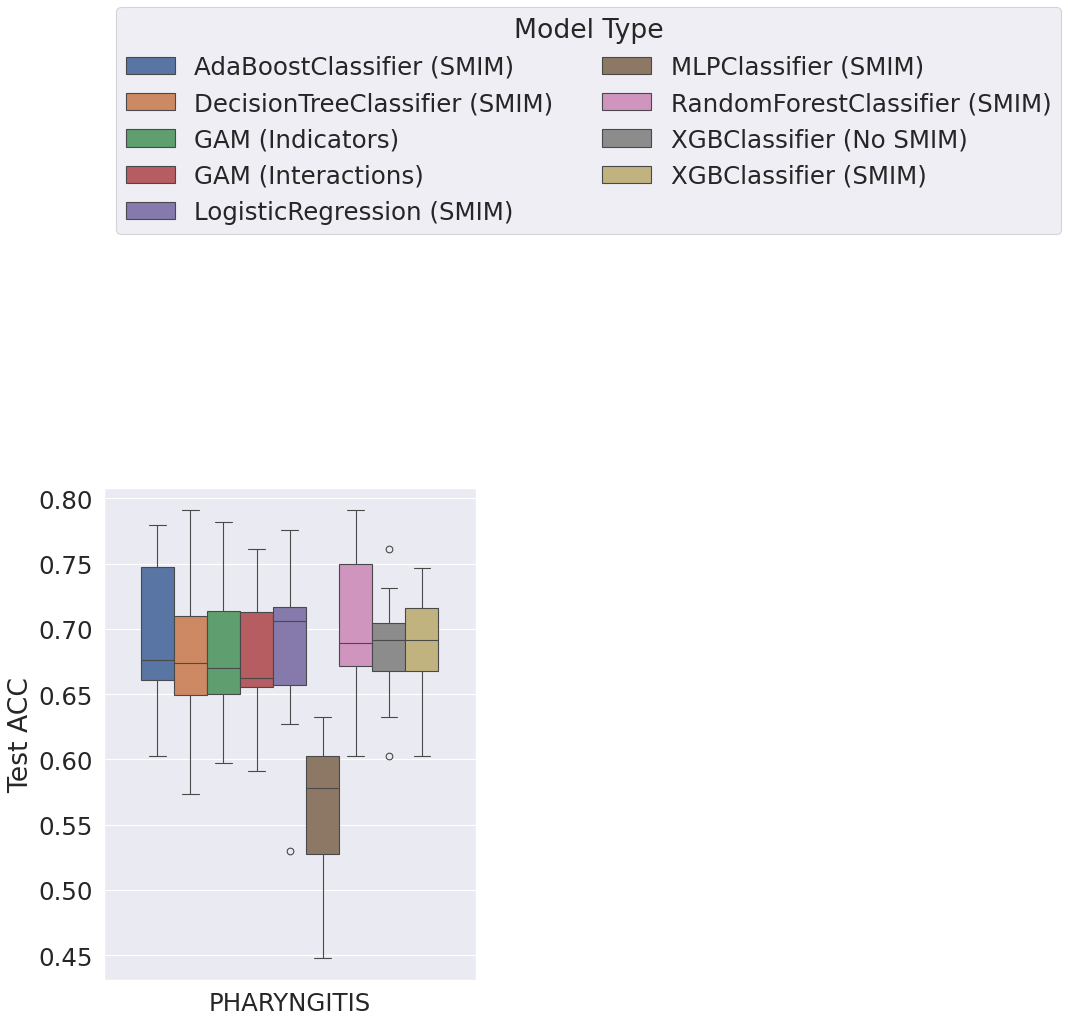

In [116]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#for dataset in acc_res['dataset'].unique():
#mask = acc_res['dataset'] == dataset
sns.set(font_scale=2.0)
figure(figsize=(6, 8), dpi=80)
ax = sns.boxplot(
    cur_acc_df, hue='Model Type', y='metric_value_test', x='dataset'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.0, 2.0), ncol=2)
plt.xlabel('')
#plt.ylim((0.75, 0.85))
#plt.title(dataset)
plt.ylabel(f'Test {target_metric.upper()}')
plt.xticks(rotation=0, ha='center')
plt.show()

## Now, we grab the runtime comparison figure

In [121]:
# Load in model fitting data
import pandas as pd
dataset_of_interest = 'PHARYNGITIS'
imputations_of_interest = ['Mean', 'MICE', 'MIWAE', 'MissForest']
target_metric = 'acc'

dfs = []
for ds_name in [f'{dataset_of_interest}', f'{dataset_of_interest}_0.25', f'{dataset_of_interest}_0.5', f'{dataset_of_interest}_0.75']:
    for imputation_method in imputations_of_interest:
        for s_iter in range(120):
            try:
                #df = pd.read_csv(f'./parallelized_results/baselines_2024-02_01_iter_{s_iter}_10_imp_all.csv')
                df = pd.read_csv(f'./parallelized_results/baselines_iter_{s_iter}_{ds_name}_{imputation_method}.csv')
                dfs.append(df)
            except:
                continue
combined_acc_df = pd.concat(dfs, axis=0)

df_list = []
for ds_name in [dataset_of_interest]:
    for imputation_method in imputations_of_interest:
        for subsample in ['', '_0.25', '_0.5', '_0.75']:
            df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_{ds_name}{subsample}_{imputation_method}_5_3.csv'))
base_timing_df = pd.concat(df_list, axis=0)

base_timing_df = base_timing_df[(base_timing_df['m'] < 10) & (base_timing_df['imputation'].isin(imputations_of_interest))]

mask = (combined_acc_df['num_imputations'] == 10) & (combined_acc_df['metric'] == target_metric)
acc_df = combined_acc_df[mask]

In [122]:
base_timing_df

,time_to_fit,time_for_train,time_for_val,time_for_test,random_state,dataset,imputation,train_percentage,test_percentage,holdout_set,validation_set,repeats,m,time_overall
0,0.001137,0.000880,0.000717,0.000675,0,PHARYNGITIS_0.25,Mean,0,0,0,0,10,0,NaN
1,0.000856,0.000764,0.000703,0.000685,1,PHARYNGITIS_0.25,Mean,0,0,0,0,10,1,NaN
2,0.000765,0.000731,0.000661,0.000670,2,PHARYNGITIS_0.25,Mean,0,0,0,0,10,2,NaN
3,0.000924,0.000708,0.000595,0.000573,3,PHARYNGITIS_0.25,Mean,0,0,0,0,10,3,NaN
4,0.000693,0.000692,0.000609,0.000586,4,PHARYNGITIS_0.25,Mean,0,0,0,0,10,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,0.000681,10.916262,10.563821,7.846199,5,PHARYNGITIS_0.75,MissForest,0,0,9,4,10,5,NaN
4496,0.000583,19.862370,11.907837,7.286419,6,PHARYNGITIS_0.75,MissForest,0,0,9,4,10,6,NaN
4497,0.000498,15.893269,10.974456,7.893986,7,PHARYNGITIS_0.75,MissForest,0,0,9,4,10,7,NaN
4498,0.000599,19.305955,10.143143,6.431979,8,PHARYNGITIS_0.75,MissForest,0,0,9,4,10,8,NaN


In [123]:
base_timing_df['dataset'].unique()

array(['PHARYNGITIS_0.25', 'PHARYNGITIS_0.5', 'PHARYNGITIS_0.75',
       'PHARYNGITIS', 'HEART_DISEASE', 'HEART_DISEASE_0.5',
       'HEART_DISEASE_0.75'], dtype=object)

In [124]:
# NOTE: This aggregation should be mean for mean imputations
base_timing_df = base_timing_df.groupby(['holdout_set', 'dataset', 'validation_set', 'imputation']).sum().reset_index()
#base_timing_df = base_timing_df.groupby(['holdout_set', 'dataset']).mean().reset_index()
#base_timing_df
#base_timing_df['holdout_set'].value_counts()

In [125]:
acc_df = acc_df.groupby(['dataset', 'holdout_set', 'model_type']).mean().reset_index()#['holdout_set'].value_counts()

merged_df = base_timing_df.merge(acc_df, how='inner', on=['dataset','holdout_set'])

# Only MICE actually records a time_overall -- the rest of the imputations
# split the time across a few phases. Aggregate those phases for plotting
mask = merged_df['time_overall'] == 0
merged_df.loc[mask, 'time_overall'] = merged_df.loc[mask, "time_to_fit"]\
    + merged_df.loc[mask, "time_for_train"]\
    + merged_df.loc[mask, "time_for_val"]\
    + merged_df.loc[mask, "time_for_test"]

# And remove the imputation time from M-GAM rows
merged_df['impute_time'] = merged_df['time_overall']

mask = (merged_df['model_type'] != 'GAM_ind') & (merged_df['model_type'] != 'GAM_aug')
merged_df['overall_time'] = 0
merged_df.loc[mask, 'overall_time'] = merged_df.loc[mask, 'impute_time'] + merged_df.loc[mask, 'mean_fit_time']
merged_df.loc[~mask, 'overall_time'] = merged_df.loc[~mask,'mean_fit_time']
merged_df.loc[~mask, 'impute_time'] = 0

/tmp/ipykernel_892048/1807515213.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc_df = acc_df.groupby(['dataset', 'holdout_set', 'model_type']).mean().reset_index()#['holdout_set'].value_counts()


In [126]:
merged_df = merged_df[merged_df['model_type'] != 'GAM_no_missing']
mask = merged_df['model_type'] == 'GAM_aug'
merged_df.loc[mask, 'model_type'] = 'GAM (Interactions)'
mask = merged_df['model_type'] == 'GAM_ind'
merged_df.loc[mask, 'model_type'] = 'GAM (Indicators)'
mask = merged_df['model_type'] == 'GAM_imputation'
merged_df.loc[mask, 'model_type'] = 'GAM (Imputation)'


/usr/xtmp/jcd97/environments/object_detection_2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#dd8452'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/xtmp/jcd97/environments/object_detection_2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#dd8452'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/xtmp/jcd97/environments/object_detection_2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#dd8452'` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/xtmp/jcd97/environments/object_detection_2/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a g

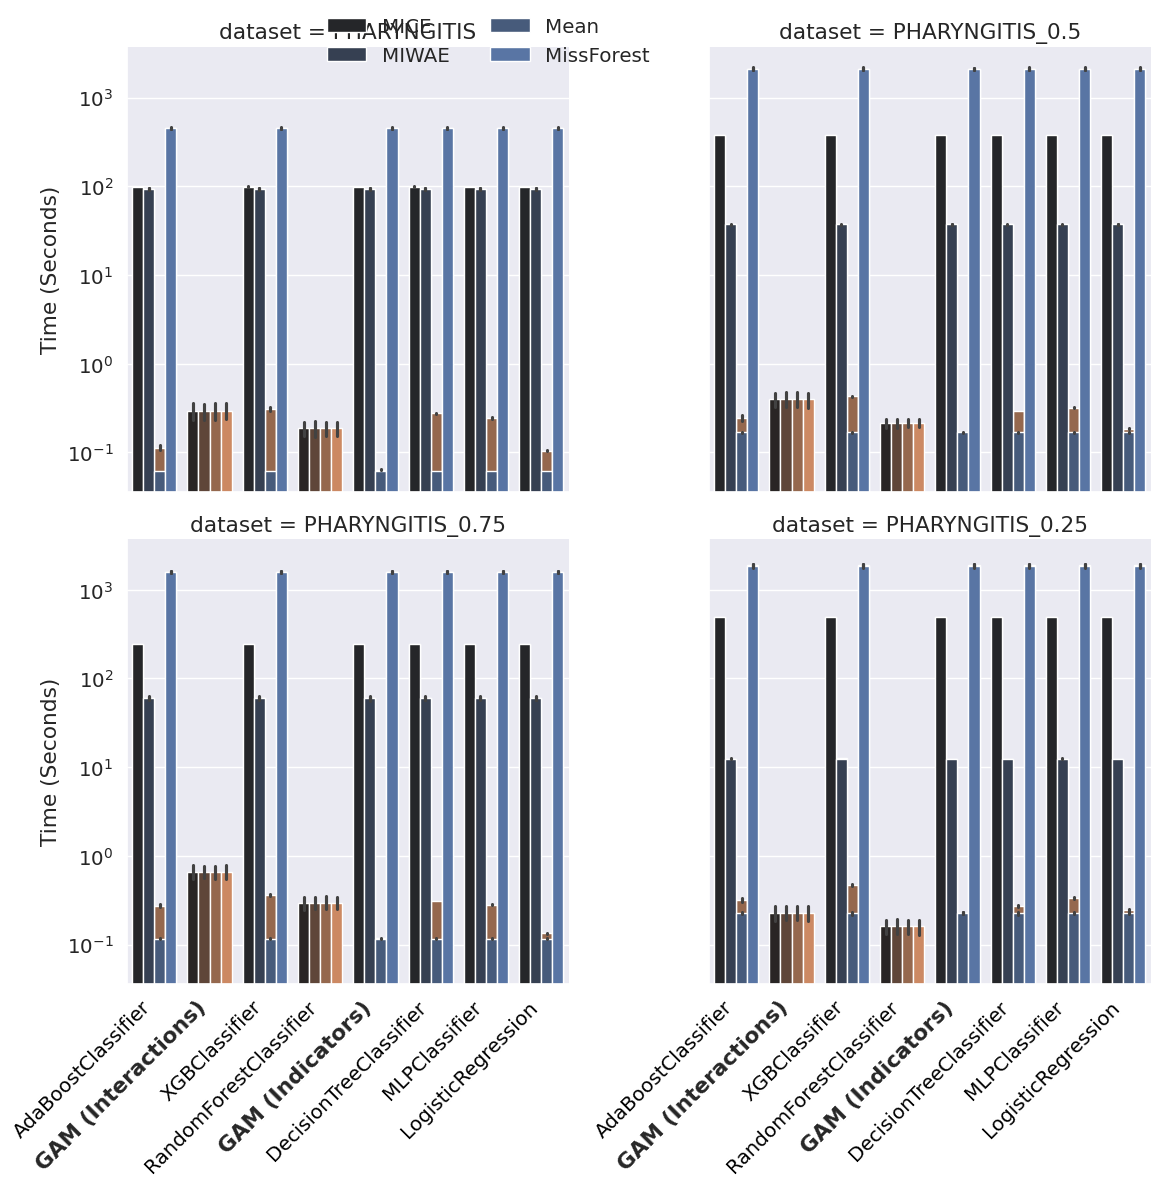

In [129]:
merged_df = merged_df.sort_values('model_type').sort_values('imputation')

color_pal = sns.color_palette()
sns.set(font_scale=1.3)
g = sns.FacetGrid(
    merged_df, 
    col="dataset", 
    col_wrap=2, 
    height=6, 
    sharey=True)
g.map_dataframe(sns.barplot,
    x='model_type',
    y='overall_time',
    hue='imputation',
    color=color_pal[1]
    #label="Model Fit Time"
    #hue='model'
).set(yscale ='log')
g.map_dataframe(sns.barplot,
    x='model_type',
    y='impute_time',
    hue='imputation',
    color=color_pal[0]
    #label="Imputation Time"
    #hue='model'
).set(yscale ='log')
g.set_xticklabels([m for m in merged_df['model_type'].unique()],
                    rotation=45, ha='right')

for tick_in, tick_label in enumerate(g.axes[-2].xaxis.get_ticklabels()):
    if merged_df['model_type'].unique()[tick_in] in ['GAM (Interactions)', 'GAM (Indicators)']:
        #tick_label.set_color("red")
        tick_label.set_font({'weight': 'bold'})
    else:
        tick_label.set_color("black")

for tick_in, tick_label in enumerate(g.axes[-1].xaxis.get_ticklabels()):
    if merged_df['model_type'].unique()[tick_in] in ['GAM (Interactions)', 'GAM (Indicators)']:
        #tick_label.set_color("red")
        tick_label.set_font({'weight': 'bold'})
    else:
        tick_label.set_color("black")
    
g.set_xlabels('')
g.set_ylabels('Time (Seconds)')

if dataset_of_interest == 'FICO':
    for ax, title in zip(g.axes.flat, ['FICO \n(2,615 Samples)', 'FICO \n(5,230 Samples)', 
                                        'FICO \n(7,844 Samples)', 'FICO \n(10,459 Samples)']):
        ax.set_title(title)
elif dataset_of_interest == 'BREAST_CANCER':
    for ax, title in zip(g.axes.flat, ['Breast Cancer \n(439 Samples)', 'Breast Cancer \n(878 Samples)', 
                                        'Breast Cancer \n(1,317 Samples)', 'Breast Cancer \n(1,756 Samples)']):
        ax.set_title(title)
plt.tight_layout()
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.25, 1.0), ncol=2)
plt.show()